In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

from sklearn.metrics import accuracy_score
from collections import deque
from datetime import datetime

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 512

# Data

In [3]:
train = FashionMNIST('./data/fashion', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data/fashion', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [4]:
print('train x:', train.train_data.size())
print('train y:', train.train_labels.size())
print('test x:', test.test_data.size())
print('test y:', test.test_labels.size())

train x: torch.Size([60000, 28, 28])
train y: torch.Size([60000])
test x: torch.Size([10000, 28, 28])
test y: torch.Size([10000])


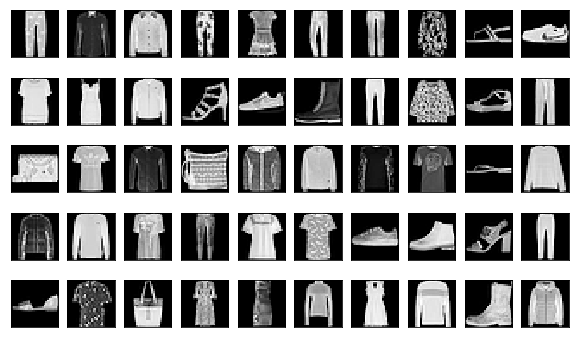

In [5]:
def visualize_data(data):
    N = data.size()[0]
    
    fig, subplots = plt.subplots(5, 10)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    subplots = subplots.reshape(-1)
    
    for subplot in subplots:
        idx = np.random.randint(0, N)
        img = train.train_data[idx].numpy()
        
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(img, cmap='gray')
        
visualize_data(train.train_data)

# Model

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channel:int=128):
        super(Discriminator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        
        self.channel:int = channel
        n_class:int = 1 # 1=진짜, 0=가짜 이기 때문에 1값으로 둔다.
        
        self.conv1 = nn.Conv2d(1, channel//3, kernel_size=4, stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(channel//3)
        
        self.conv2 = nn.Conv2d(channel//3, channel//2, kernel_size=4, stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(channel//2)
        
        self.conv3 = nn.Conv2d(channel//2, channel, kernel_size=4, stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(channel)
        
        # Global Average Pooling
        self.conv4 = nn.Conv2d(channel, n_class, kernel_size=4, stride=2, padding=4)

    def forward(self, x):
        h = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        h = F.leaky_relu(self.bn2(self.conv2(h)), negative_slope=0.2)
        h = F.leaky_relu(self.bn3(self.conv3(h)), negative_slope=0.2)
        
        # Global Average Pooling
        h = F.leaky_relu(self.conv4(h), negative_slope=0.2)
        h = F.avg_pool2d(h, kernel_size=h.size()[2:]).view(h.size()[0], -1)
        output = F.sigmoid(h)
        return output
        
D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

# noise = Variable(torch.randn((2, 100, 1, 1)).cuda())
# D(G(noise))

Discriminator(
  (conv1): Conv2d (1, 42, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (42, 64, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
)


## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, noise:int=100, channel:int=128):
        super(Generator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        _c = channel
        
        self.noise = noise
        
        self.tp_conv1 = nn.ConvTranspose2d(noise, _c*4, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(_c*4)
        
        self.tp_conv2 = nn.ConvTranspose2d(_c*4, _c*3, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(_c*3)
        
        self.tp_conv3 = nn.ConvTranspose2d(_c*3, _c*2, kernel_size=5, stride=2, padding=2, bias=False)
        self.bn3 = nn.BatchNorm2d(_c*2)
                
        self.tp_conv4 = nn.ConvTranspose2d(_c*2, _c, kernel_size=6, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(_c)
        
        self.tp_conv5 = nn.ConvTranspose2d(_c, 1, kernel_size=7, stride=1, padding=1, bias=False)
    
    def forward(self, noise):
        h = self.tp_conv1(noise)
        h = F.relu(self.bn1(h))
#         print('h1', h.size())
        
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))
#         print('h2', h.size())
        
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))
#         print('h3', h.size())

        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))
        
        h = self.tp_conv5(h)
        h = F.sigmoid(h)
#         print('h6', h.size())
        return h
    

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

noise = Variable(torch.randn((2, 100, 1, 1)).cuda())
G(noise).size()

Generator(
  (tp_conv1): ConvTranspose2d (100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv2): ConvTranspose2d (512, 384, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv3): ConvTranspose2d (384, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv4): ConvTranspose2d (256, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv5): ConvTranspose2d (128, 1, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
)


torch.Size([2, 1, 28, 28])

## Load Model

In [8]:
import os

def load_model(file='dcgan_mnist.pth.tar'):
    divergences, d_losses, g_losses, d_fake_losses, d_real_losses = None, None, None, None, None
    if os.path.exists(file):
        checkpoint = torch.load(file)
        G.load_state_dict(checkpoint['G'])
        D.load_state_dict(checkpoint['D'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer'])

        divergences = checkpoint['divergence']
        d_losses = checkpoint['d_losses']
        g_losses = checkpoint['g_losses']
        d_fake_losses = checkpoint['d_fake_losses']
        d_real_losses = checkpoint['d_real_losses']
    return divergences, d_losses, g_losses, d_fake_losses, d_real_losses
divergences, d_losses, g_losses, d_fake_losses, d_real_losses = load_model()

# Train

In [9]:
N_EPOCH = 600

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [10]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
_time = datetime.now()

for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        _batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((_batch_size, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y[:_batch_size])
        
        # Calculate the loss with fake images
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_fake_pred = D(G(noise).detach())
        d_fake_loss = loss_f(y_fake_pred, fake_y[:_batch_size])
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_pred = D(G(noise))
        g_loss = loss_f(y_pred, real_y[:_batch_size])
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 10 == 0:
            _time_delta = round((datetime.now() - _time).total_seconds(), 2)
            
            
            print(f'\rsec:{_time_delta:<6} [{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])),
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), end='')
    _time = datetime.now()
    print()

sec:45.2   [1/600] divergence: 0.561    D: 0.682    G:0.781    D_real: 0.472    D_fake: 0.682   
sec:46.75  [2/600] divergence: 0.614    D: 0.569    G:1.04     D_real: 0.431    D_fake: 0.569   
sec:45.96  [3/600] divergence: 0.669    D: 0.48     G:1.28     D_real: 0.359    D_fake: 0.48    
sec:45.3   [4/600] divergence: 0.693    D: 0.446    G:1.41     D_real: 0.334    D_fake: 0.446   
sec:45.36  [5/600] divergence: 0.779    D: 0.309    G:1.97     D_real: 0.234    D_fake: 0.309   
sec:45.43  [6/600] divergence: 0.845    D: 0.216    G:2.6      D_real: 0.167    D_fake: 0.216   
sec:45.5   [7/600] divergence: 0.87     D: 0.178    G:2.85     D_real: 0.147    D_fake: 0.178   
sec:45.54  [8/600] divergence: 0.91     D: 0.12     G:3.31     D_real: 0.0985   D_fake: 0.12    
sec:45.57  [9/600] divergence: 0.925    D: 0.101    G:3.63     D_real: 0.0898   D_fake: 0.101   
sec:45.58  [10/600] divergence: 0.912    D: 0.116    G:3.43     D_real: 0.112    D_fake: 0.116   
sec:45.51  [11/600] divergenc

sec:44.13  [84/600] divergence: 1.0      D: 9.42e-06 G:11.7     D_real: 1.25e-06 D_fake: 9.42e-06
sec:44.36  [85/600] divergence: 1.0      D: 8.55e-06 G:11.8     D_real: 1.12e-06 D_fake: 8.55e-06
sec:44.3   [86/600] divergence: 1.0      D: 7.46e-06 G:11.9     D_real: 9.9e-07  D_fake: 7.46e-06
sec:44.7   [87/600] divergence: 1.0      D: 6.39e-06 G:12.1     D_real: 8.93e-07 D_fake: 6.39e-06
sec:44.4   [88/600] divergence: 1.0      D: 5.52e-06 G:12.3     D_real: 8.42e-07 D_fake: 5.52e-06
sec:44.35  [89/600] divergence: 1.0      D: 4.56e-06 G:12.5     D_real: 7.53e-07 D_fake: 4.56e-06
sec:44.03  [90/600] divergence: 1.0      D: 4.17e-06 G:12.5     D_real: 7.21e-07 D_fake: 4.17e-06
sec:44.5   [91/600] divergence: 1.0      D: 3.91e-06 G:12.6     D_real: 6.76e-07 D_fake: 3.91e-06
sec:44.3   [92/600] divergence: 1.0      D: 3.58e-06 G:12.8     D_real: 6.4e-07  D_fake: 3.58e-06
sec:44.12  [93/600] divergence: 1.0      D: 4.18e-06 G:12.6     D_real: 6.17e-07 D_fake: 4.18e-06
sec:44.41  [94/600] 

sec:43.91  [166/600] divergence: 1.0      D: 5.84e-08 G:16.9     D_real: 6.02e-09 D_fake: 5.84e-08
sec:44.06  [167/600] divergence: 1.0      D: 5.9e-08  G:17.0     D_real: 5.29e-09 D_fake: 5.9e-08 
sec:44.07  [168/600] divergence: 1.0      D: 5.91e-08 G:17.1     D_real: 4.78e-09 D_fake: 5.91e-08
sec:44.3   [169/600] divergence: 1.0      D: 5.44e-08 G:17.2     D_real: 4.43e-09 D_fake: 5.44e-08
sec:43.77  [170/600] divergence: 1.0      D: 4.5e-08  G:17.3     D_real: 4.15e-09 D_fake: 4.5e-08 
sec:44.34  [171/600] divergence: 1.0      D: 3.49e-08 G:17.3     D_real: 3.56e-09 D_fake: 3.49e-08
sec:44.02  [172/600] divergence: 1.0      D: 2.08e-08 G:17.4     D_real: 3.13e-09 D_fake: 2.08e-08
sec:44.24  [173/600] divergence: 1.0      D: 1.01e-08 G:17.5     D_real: 2.82e-09 D_fake: 1.01e-08
sec:44.02  [174/600] divergence: 1.0      D: 4.76e-09 G:17.6     D_real: 2.52e-09 D_fake: 4.76e-09
sec:43.87  [175/600] divergence: 1.0      D: 3.03e-11 G:17.6     D_real: 2.77e-09 D_fake: 3.03e-11
sec:43.95 

sec:44.49  [248/600] divergence: 0.983    D: 0.017    G:5.12     D_real: 0.0191   D_fake: 0.017   
sec:44.59  [249/600] divergence: 0.984    D: 0.0161   G:5.19     D_real: 0.0178   D_fake: 0.0161  
sec:44.56  [250/600] divergence: 0.985    D: 0.0153   G:5.13     D_real: 0.0149   D_fake: 0.0153  
sec:44.32  [251/600] divergence: 0.984    D: 0.0164   G:5.02     D_real: 0.0176   D_fake: 0.0164  
sec:44.37  [252/600] divergence: 0.977    D: 0.0273   G:4.86     D_real: 0.027    D_fake: 0.0273  
sec:44.36  [253/600] divergence: 0.977    D: 0.0278   G:4.83     D_real: 0.028    D_fake: 0.0278  
sec:44.35  [254/600] divergence: 0.965    D: 0.0443   G:4.67     D_real: 0.038    D_fake: 0.0443  
sec:44.4   [255/600] divergence: 0.956    D: 0.0536   G:4.51     D_real: 0.0602   D_fake: 0.0536  
sec:44.11  [256/600] divergence: 0.956    D: 0.0531   G:4.37     D_real: 0.0619   D_fake: 0.0531  
sec:44.58  [257/600] divergence: 0.955    D: 0.0538   G:4.4      D_real: 0.0639   D_fake: 0.0538  
sec:44.24 

sec:44.01  [330/600] divergence: 0.936    D: 0.0776   G:3.78     D_real: 0.0774   D_fake: 0.0776  
sec:44.17  [331/600] divergence: 0.939    D: 0.0718   G:3.79     D_real: 0.0923   D_fake: 0.0718  
sec:44.14  [332/600] divergence: 0.929    D: 0.0856   G:3.78     D_real: 0.0892   D_fake: 0.0856  
sec:43.72  [333/600] divergence: 0.928    D: 0.0874   G:3.88     D_real: 0.0833   D_fake: 0.0874  
sec:44.05  [334/600] divergence: 0.935    D: 0.0756   G:3.84     D_real: 0.076    D_fake: 0.0756  
sec:44.02  [335/600] divergence: 0.941    D: 0.0677   G:3.87     D_real: 0.0692   D_fake: 0.0677  
sec:43.94  [336/600] divergence: 0.944    D: 0.0649   G:3.93     D_real: 0.0621   D_fake: 0.0649  
sec:43.83  [337/600] divergence: 0.949    D: 0.0588   G:3.96     D_real: 0.0626   D_fake: 0.0588  
sec:44.02  [338/600] divergence: 0.957    D: 0.0484   G:4.11     D_real: 0.0554   D_fake: 0.0484  
sec:43.92  [339/600] divergence: 0.961    D: 0.0441   G:4.2      D_real: 0.0438   D_fake: 0.0441  
sec:44.17 

sec:44.29  [412/600] divergence: 0.948    D: 0.0617   G:4.25     D_real: 0.0752   D_fake: 0.0617  
sec:44.42  [413/600] divergence: 0.953    D: 0.0562   G:4.3      D_real: 0.0678   D_fake: 0.0562  
sec:44.34  [414/600] divergence: 0.96     D: 0.0462   G:4.4      D_real: 0.048    D_fake: 0.0462  
sec:44.28  [415/600] divergence: 0.966    D: 0.0382   G:4.37     D_real: 0.0373   D_fake: 0.0382  
sec:44.22  [416/600] divergence: 0.966    D: 0.0388   G:4.58     D_real: 0.0376   D_fake: 0.0388  
sec:44.32  [417/600] divergence: 0.961    D: 0.0445   G:4.46     D_real: 0.0458   D_fake: 0.0445  
sec:44.26  [418/600] divergence: 0.961    D: 0.0432   G:4.44     D_real: 0.0547   D_fake: 0.0432  
sec:44.22  [419/600] divergence: 0.956    D: 0.0498   G:4.37     D_real: 0.055    D_fake: 0.0498  
sec:44.33  [420/600] divergence: 0.953    D: 0.0539   G:4.15     D_real: 0.0571   D_fake: 0.0539  
sec:44.27  [421/600] divergence: 0.955    D: 0.0506   G:4.16     D_real: 0.0579   D_fake: 0.0506  
sec:44.25 

sec:44.36  [494/600] divergence: 0.967    D: 0.0417   G:4.54     D_real: 0.0307   D_fake: 0.0417  
sec:43.99  [495/600] divergence: 0.96     D: 0.0511   G:4.42     D_real: 0.0308   D_fake: 0.0511  
sec:44.32  [496/600] divergence: 0.959    D: 0.0521   G:4.47     D_real: 0.0335   D_fake: 0.0521  
sec:44.12  [497/600] divergence: 0.965    D: 0.0413   G:4.74     D_real: 0.0334   D_fake: 0.0413  
sec:44.16  [498/600] divergence: 0.97     D: 0.0349   G:4.79     D_real: 0.0352   D_fake: 0.0349  
sec:44.3   [499/600] divergence: 0.976    D: 0.0261   G:4.9      D_real: 0.0318   D_fake: 0.0261  
sec:43.91  [500/600] divergence: 0.966    D: 0.0492   G:4.92     D_real: 0.0372   D_fake: 0.0492  
sec:44.22  [501/600] divergence: 0.957    D: 0.0593   G:4.71     D_real: 0.0428   D_fake: 0.0593  
sec:44.02  [502/600] divergence: 0.957    D: 0.0596   G:4.69     D_real: 0.0438   D_fake: 0.0596  
sec:44.07  [503/600] divergence: 0.946    D: 0.0869   G:4.87     D_real: 0.0848   D_fake: 0.0869  
sec:43.84 

sec:43.62  [576/600] divergence: 0.965    D: 0.0436   G:4.48     D_real: 0.0493   D_fake: 0.0436  
sec:44.2   [577/600] divergence: 0.972    D: 0.0318   G:4.59     D_real: 0.0378   D_fake: 0.0318  
sec:43.93  [578/600] divergence: 0.975    D: 0.0269   G:4.69     D_real: 0.0353   D_fake: 0.0269  
sec:44.26  [579/600] divergence: 0.98     D: 0.0217   G:4.78     D_real: 0.0239   D_fake: 0.0217  
sec:44.01  [580/600] divergence: 0.982    D: 0.019    G:5.08     D_real: 0.0209   D_fake: 0.019   
sec:44.13  [581/600] divergence: 0.982    D: 0.0192   G:5.1      D_real: 0.0233   D_fake: 0.0192  
sec:44.12  [582/600] divergence: 0.973    D: 0.0326   G:4.95     D_real: 0.028    D_fake: 0.0326  
sec:43.91  [583/600] divergence: 0.962    D: 0.0529   G:4.78     D_real: 0.0407   D_fake: 0.0529  
sec:44.16  [584/600] divergence: 0.961    D: 0.0542   G:4.54     D_real: 0.0485   D_fake: 0.0542  
sec:44.25  [585/600] divergence: 0.959    D: 0.0568   G:4.6      D_real: 0.0488   D_fake: 0.0568  
sec:43.98 

## Save Model

In [11]:
def save_moodel():
    check_point = {'G': G.state_dict(), 
                   'D': D.state_dict(), 
                   'g_optimizer': g_optimizer.state_dict(),
                   'd_optimizer': d_optimizer.state_dict(),
                   'divergence': divergences, 
                   'd_losses': d_losses, 
                   'g_losses': g_losses, 
                   'd_fake_losses': d_fake_losses, 
                   'd_real_losses': d_real_losses}
    torch.save(check_point, 'dcgan-simple.pth.tar')
save_moodel()

## Loss Visualization

In [12]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

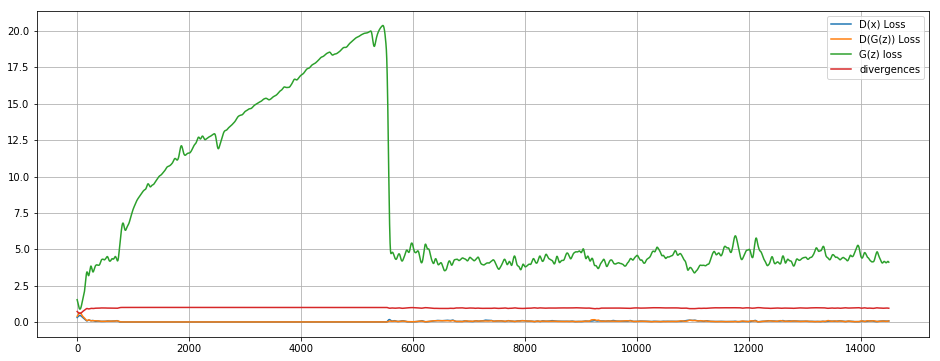

In [13]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

## Generator Evaluation

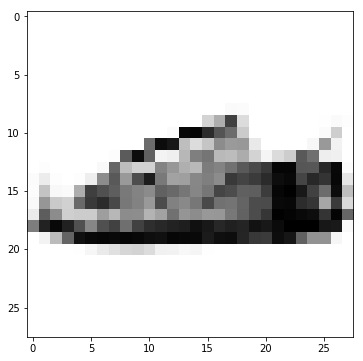

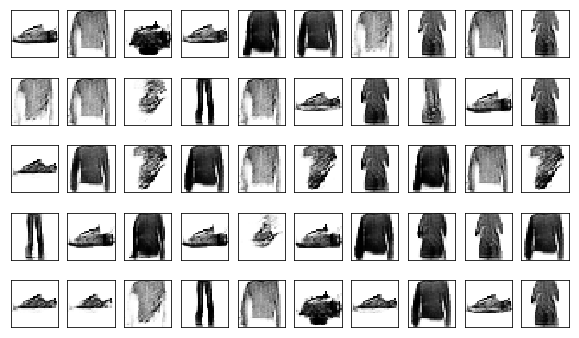

In [15]:
noise = Variable(torch.randn((128, 100, 1, 1)).cuda())
images = G(noise).view((-1, 28, 28)).data.cpu().numpy()
images = (images * 255).astype(np.uint8)
imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(5, 10) # subplots(y축, x축 갯수)
fig.set_figheight(6)
fig.set_figwidth(10)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1